# Import Libraries

In [1]:
# Data fetching library
import requests as req
# used below: 'res' stands for 'response'

# File management library
import os

# Configure logging library
import logging
import sys
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

# Data manipulation libraries
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
import json
from datetime import datetime

# Data analysis libraries
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Uploading results to Carto
import cartoframes

# Data visualization library
## Uses Vega-Lite, which can be easily put in websites
from vega3 import Vega
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data from RW API

In [ ]:
# Base URL for getting dataset metadata from RW API
url = "https://api.resourcewatch.org/v1/dataset?sort=slug,-provider,userId&status=saved&published=true&includes=metadata,vocabulary,widget,layer"

# page[size] tells the API the maximum number of results to send back
# There are currently between 200 and 300 datasets on the RW API
payload = { "application":"rw", "page[size]": 1000}

# Request all datasets, and extract the data from the response
res = req.get(url, params=payload)
data = res.json()["data"]

### Convert the json object returned by the API into a pandas DataFrame
# Another option: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html
datasets_on_api = {}
for ix, dset in enumerate(data):
    atts = dset["attributes"]
    metadata = atts["metadata"]
    layers = atts["layer"]
    widgets = atts["widget"]
    tags = atts["vocabulary"]
    datasets_on_api[dset["id"]] = {
        "name":atts["name"],
        "table_name":atts["tableName"],
        "provider":atts["provider"],
        "date_updated":atts["updatedAt"],
        "num_metadata":len(metadata),
        "metadata": metadata,
        "num_layers":len(layers),
        "layers": layers,
        "num_widgets":len(widgets),
        "widgets": widgets,
        "num_tags":len(tags),
        "tags":tags
    }

# Create the DataFrame, name the index, and sort by date_updated
# More recently updated datasets at the top
current_datasets_on_api = pd.DataFrame.from_dict(datasets_on_api, orient='index')
current_datasets_on_api.index.rename("Dataset", inplace=True)
current_datasets_on_api.sort_values(by=["date_updated"], inplace=True, ascending = False)

# Select all Carto datasets on the API:
provider = "cartodb"
carto_ids = (current_datasets_on_api["provider"]==provider)
carto_data = current_datasets_on_api.loc[carto_ids]

logging.info("Number of Carto datasets: " + str(carto_data.shape[0]))

# Find data sets to run the analysis with

In [ ]:
# Select only national level data sets

def pick_spatial_resolution(mdatas):
    for mdata in mdatas:
        if mdata['attributes']['language'] == 'en':
            return mdata['attributes']['info'].get('spatial_resolution', None)

def pick_temporal_resolution(mdatas):
    for mdata in mdatas:
        if mdata['attributes']['language'] == 'en':
            return mdata['attributes']['info'].get('frequency_of_updates', None)
        
carto_data.loc[:,'spatial_resolution'] = list(map(pick_spatial_resolution, carto_data['metadata']))
carto_data.loc[:,'temporal_resolution'] = list(map(pick_temporal_resolution, carto_data['metadata']))

national_datasets = carto_data[carto_data['spatial_resolution'] == 'National']
annual_national_datasets = national_datasets[national_datasets['temporal_resolution'] == 'Annual']

logging.info("{} annual, national level data sets".format(annual_national_datasets.shape[0]))
annual_national_datasets.shape

In [ ]:
# Exclude MaterialFlows as this is handled in another notebook
annual_national_datasets.drop('082e2262-c58e-46a0-b6b7-56083cfcbd34', inplace=True)

## Find which data sets cover the right years and are "simple"

### Find year column

In [ ]:
def inquire_columns(info):
    ds_id, table_name = info
    print(ds_id)
    # Template query string used to query RW datasets
    q = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT * FROM {} LIMIT 1".format(ds_id,table_name)
    try:
        res = req.get(q).json()['data'][0]
        keys = res.keys()
        types = [type(val) for key, val in res.items()]
        return (keys, types)
    except:
        return (None, None)
    
# Collect column names
annual_national_datasets.loc[:, 'column_names'], annual_national_datasets.loc[:, 'column_types'] = zip(*list(map(inquire_columns, zip(annual_national_datasets.index,annual_national_datasets['table_name']))))

In [ ]:
ix = 3
print(annual_national_datasets.iloc[ix]['column_names'])
print(annual_national_datasets.iloc[ix]['column_types'])

In [ ]:
# Making the choice to only accept datetime and year as column names.
# Datetimes will be string timestamps, years will be ints
def pick_year_col(column_names):
    print("Available column names: {}".format(column_names))
    if 'datetime' in column_names:
        return 'datetime'
    elif 'year' in column_names:
        return 'year'
    else:
        return None
        #year_col = input("What is the year column called? Type nothing for None")
        #return year_col if year_col else None

annual_national_datasets.loc[:, 'year_col'] = list(map(pick_year_col, annual_national_datasets['column_names']))

In [ ]:
annual_national_datasets['year_col']

### Find dates covered by each dataset

In [ ]:
def try_datetime_conversion_to_year(possible_dt):
    DATE_FORMAT = '%Y-%m-%dT%H:%M:%SZ'
    try:
        return datetime.strptime(possible_dt, DATE_FORMAT).year
    except:
        return int(possible_dt)

def find_years_covered(info):
    ds_id, year_col, table_name = info
    if year_col:
        print(ds_id)
        # Template query string used to query RW datasets
        q = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {} FROM {}".format(ds_id,year_col,table_name)
        print(q)
        try:
            res = pd.DataFrame(req.get(q).json()['data'])
            unique_years = res[year_col].unique()
            print(unique_years)
            int_years = list(map(try_datetime_conversion_to_year, unique_years))
            return sorted(int_years)
        except:
            return None
    else:
        return None
    
annual_national_datasets.loc[:, 'years_covered'] = list(map(find_years_covered, zip(annual_national_datasets.index, annual_national_datasets['year_col'], annual_national_datasets['table_name'])))

In [ ]:
annual_national_datasets['years_covered']

In [ ]:
def determine_if_analysis_possible(years_covered):
    flag = False
    try:
        if (2000 in years_covered) and (2015 in years_covered):
            flag = True
    except:
        pass
    return flag

annual_national_datasets.loc[:, 'analysis_possible'] = list(map(determine_if_analysis_possible, annual_national_datasets['years_covered']))

In [ ]:
annual_national_datasets['analysis_possible'] 

### Pick the value column to use

In [ ]:
def pick_value_col(info):
    analysis_possible = info[0]
    column_names = info[1]
    if analysis_possible:
        print("Available column names: {}".format(column_names))
        if 'yr_data' in column_names:
            return 'yr_data'
        elif 'total_data' in column_names:
            return 'total_data'
        else:
            value_col = input("What is the value column called? Type nothing for None")
            return value_col if value_col else None
    else:
        return None

annual_national_datasets.loc[:, 'value_col'] = list(map(pick_value_col, zip(annual_national_datasets['analysis_possible'], annual_national_datasets['column_names'])))

### Pick the country column to use

In [ ]:
def pick_country_col(column_names):
    print("Available column names: {}".format(column_names))
    if 'rw_country_code' in column_names:
        return 'rw_country_code'
    else:
        country_col = input("What is the country column called? Type nothing for None")
        return country_col if country_col else None

annual_national_datasets.loc[:, 'country_col'] = list(map(pick_country_col, annual_national_datasets['column_names']))

### Preview datasets to run analysis with

In [ ]:
analyse_these = annual_national_datasets[annual_national_datasets['analysis_possible']==True]

analyse_these

# Run the analysis

In [ ]:
def run_linear_regressions(datax, xyear, xval_col, xcountry_col, xname,
                           datay_from_rwapi, ystartyear, yendyear,
                           test_size):
    ''' 
    Inputs: Data and needed column names
    Outputs: square matrix of regression coefficients for each indicator
    '''
    
    #datay_from_rw_api
    #yprod_col, yflow_col,yyear_col, yval_col,ycountry_col,
    
    # Result will be an upper right triangular square matrix in 4 dimensions
    results = {}    
    
    all_countries = datax[xcountry_col].unique()
    msg = "regressing GHG-GDP Divergence Index against {}"
    q_yr = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {}, {} FROM {} WHERE {}={}"#.format(ds_id,value_col,country_col,table_name,year_col,target_year)
    q_dt = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {}, {} FROM {} WHERE EXTRACT(year from {})={}"#.format(ds_id,value_col,country_col,table_name,year_col,target_year)
    
    for ds in datay_from_rwapi.iterrows():
        
        ds_id = ds[0]        
        table_name = ds[1]['table_name']
        year_col = ds[1]['year_col']
        value_col = ds[1]['value_col']
        country_col = ds[1]['country_col']
        
        if not (year_col and value_col and country_col and table_name):
            results[ds_id] = 'Some missing information'
            continue
        
        logging.info(msg.format(table_name))
    
        # Extract data
        # TO DO: allow for year ranges
        data_x = datax.copy()

        if year_col == 'datetime':
            res = req.get(q_dt.format(ds_id,value_col,country_col,table_name,year_col,ystartyear))
        elif year_col == 'year':
            res = req.get(q_yr.format(ds_id,value_col,country_col,table_name,year_col,ystartyear))
        else:
            continue
            
        try:
            data_y_start = pd.DataFrame(res.json()['data'])
        except:
            print(res.text)
            
        data_y_start = data_y_start.set_index(country_col)
        # Avoid division by 0
        data_y_start = data_y_start.loc[data_y_start[value_col] > 0]

        if year_col == 'datetime':
            res = req.get(q_dt.format(ds_id,value_col,country_col,table_name,year_col,yendyear))
        elif year_col == 'year':
            res = req.get(q_yr.format(ds_id,value_col,country_col,table_name,year_col,yendyear))
        else:
            continue
        
        try:
            data_y_end = pd.DataFrame(res.json()['data'])
        except:
            print(res.text)        
            
        data_y_end = data_y_end.set_index(country_col)

        logging.debug('Start {}'.format(data_y_start.head()))
        logging.debug('End {}'.format(data_y_end.head()))

        data_y = data_y_end[value_col].div(data_y_start[value_col])
        data_y = data_y[pd.notnull(data_y)]
        logging.debug('Change percent: {}'.format(data_y.head()))

        # Throw away all but intersection of countries
        logging.debug('data_x countries: {}'.format(set(data_x[xcountry_col])))
        logging.debug('data_y countries: {}'.format(set(data_y.index)))
        keep_countries = set(data_x[xcountry_col]) & set(data_y.index)
        skipped_countries = [country for country in all_countries if country not in keep_countries]

        data_x = data_x.set_index(xcountry_col).loc[keep_countries, xval_col]
        data_y = data_y.loc[keep_countries]

        # Reshape for regression
        data_x_reg = data_x.values.reshape(-1, 1)
        data_y_reg = data_y.values.reshape(-1, 1)

        if (len(data_x_reg)>test_size) & (len(data_y_reg)>test_size):
            pass
        else:
            results[ds_id] = {
                'r_squared': None,
                'skipped_countries': skipped_countries
            }
            continue

        # Split for training / test set
        X_train, X_test, y_train, y_test = train_test_split(data_x_reg, data_y_reg, 
                                                            test_size=test_size, random_state=42)

        # Run regression
        lm = linear_model.LinearRegression() 
        lm.fit(X_train, y_train)

        # Extract coefficient of determination (r^2)
        r_squared = lm.score(X_test, y_test)
        #y_pred = lm.predict(X_test)
        #r_squared2 = metrics.r2_score(y_test, y_pred)

        logging.info('rsquared: {}'.format(r_squared)) #, r_squared2))
        logging.info('num skipped countries: {}'.format(len(skipped_countries)))
        logging.info('num training countries: {}'.format(len(X_train)))
        logging.info('num testing countries: {}'.format(len(X_test)))

        # Store results
        results[ds_id] = {
            'r_squared': r_squared,
            'skipped_countries': skipped_countries
        }
        
        if r_squared > .02:
            results[ds_id]['data_x'] = data_x
            results[ds_id]['data_y'] = data_y
            
    return results    

In [ ]:
DATAX = pd.read_csv('/Users/nathansuberi/Documents/GitHub/nsuberi.github.io/Compass Degrees for Summary Period.csv')
kwargs = {
    'datax': DATAX,
    'xname':'compass of divergence',
    'xyear': None,
    'xval_col': 'prod_degree',
    'xcountry_col': 'country',
    'datay_from_rwapi': annual_national_datasets[annual_national_datasets['analysis_possible']==True],
    'ystartyear': 2000,
    'yendyear': 2015,
    'test_size':30
}

regression_results = run_linear_regressions(**kwargs)

In [ ]:
#logging.info('Number of regressions attempted: {}'.format(len(regression_results)))
#logging.info('Results: {}'.format(regression_results))

def pick_not_null(d):
    new_d = dict()
    for key, vals in d.items():
        if vals['r_squared']:
            new_d[key] = vals
    return new_d

notnull_results = pick_not_null(regression_results)


sorted_results = sorted(notnull_results.items(), 
                        key=lambda res: res[1]['r_squared'], 
                        reverse=True)
             
# Only keep non-perfect correlations, 
# and ones for which no more than 10 countries are skipped
filterd_sorted_results = [res for res in sorted_results if 
                  (res[1]['r_squared'] < 1) and 
                  (len(res[1]['skipped_countries']) < 40) ]

filterd_sorted_results

In [ ]:
analyse_these.loc['37d04efc-0ab2-4499-a891-54dca1013c74']

# Upload the results to Carto and RW API

## Authenticate to Carto

In [5]:
CARTO_USER = 'wri-rw'
CARTO_KEY = os.environ.get('CARTO_KEY', None)

cc = cartoframes.CartoContext(base_url='https://{}.carto.com/'.format(CARTO_USER),
                              api_key=CARTO_KEY)

## Format and upload table

In [7]:
x = filterd_sorted_results[0][1]['data_x'].values
y = filterd_sorted_results[0][1]['data_y'].values
df = pd.DataFrame({'x':x, 'y':y})
cc.write(df, 'com_xxx_ghg_gdp_highest_correlated_results', overwrite=True)

### Temporary - display results with matplotlib

In [8]:
data = cc.read('com_xxx_ghg_gdp_highest_correlated_results')

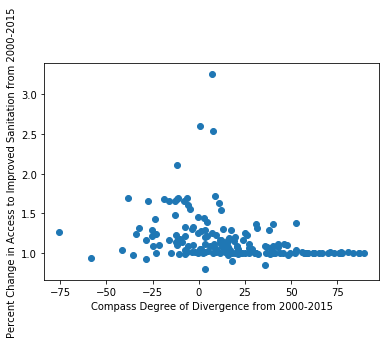

In [9]:
data = data[['x', 'y']]
plt.scatter(data['x'], data['y'])
plt.ylabel('Percent Change in Access to Improved Sanitation from 2000-2015')
plt.xlabel('Compass Degree of Divergence from 2000-2015')

# Configure the vega chart output, which can be uploaded to the RW API

### TO DO - make this actually work

In [ ]:
Config=''.join([
    "{\n",
    "  \"range\": {\n",
    "    \"dotSize\": [20, 250],\n",
    "    \"category\": [\n",
    "      \"#3BB2D0\",\n",
    "      \"#2C75B0\",\n",
    "      \"#FAB72E\",\n",
    "      \"#EF4848\",\n",
    "      \"#65B60D\",\n",
    "      \"#717171\"\n",
    "    ],\n",
    "    \"category20\": [\n",
    "      \"#3BB2D0\",\n",
    "      \"#2C75B0\",\n",
    "      \"#FAB72E\",\n",
    "      \"#EF4848\",\n",
    "      \"#65B60D\",\n",
    "      \"#C32D7B\",\n",
    "      \"#F577B9\",\n",
    "      \"#5FD2B8\",\n",
    "      \"#F1800F\",\n",
    "      \"#9F1C00\",\n",
    "      \"#A5E9E3\",\n",
    "      \"#B9D765\",\n",
    "      \"#393F44\",\n",
    "      \"#CACCD0\",\n",
    "      \"#717171\"\n",
    "    ],\n",
    "    \"ordinal\": { \"scheme\": \"greens\" },\n",
    "    \"ramp\": { \"scheme\": \"purples\" }\n",
    "  },\n",
    "  \"axis\": {\n",
    "    \"labelFontSize\": 13,\n",
    "    \"labelFont\": \"Lato\",\n",
    "    \"labelColor\": \"#717171\",\n",
    "    \"labelPadding\": 10,\n",
    "    \"ticks\": true,\n",
    "    \"tickSize\": 5,\n",
    "    \"tickColor\": \"#A9ABAD\",\n",
    "    \"tickOpacity\": 0.5,\n",
    "    \"tickExtra\": false\n",
    "  },\n",
    "  \"axisX\": {\n",
    "    \"bandPosition\": 0.5,\n",
    "    \"domainWidth\": 1.2,\n",
    "    \"domainColor\": \"#A9ABAD\",\n",
    "    \"labelAlign\": \"center\",\n",
    "    \"labelBaseline\": \"top\"\n",
    "  },\n",
    "  \"axisY\": {\n",
    "    \"domain\": false,\n",
    "    \"labelAlign\": \"left\",\n",
    "    \"labelBaseline\": \"bottom\",\n",
    "    \"tickOpacity\": 0.5,\n",
    "    \"grid\": true,\n",
    "    \"ticks\": false,\n",
    "    \"gridColor\": \"#A9ABAD\",\n",
    "    \"gridOpacity\": 0.5\n",
    "  },\n",
    "  \"mark\": {\n",
    "    \"fill\": \"#3BB2D0\"\n",
    "  },\n",
    "  \"symbol\": {\n",
    "    \"fill\": \"#3BB2D0\",\n",
    "    \"stroke\": \"#fff\"\n",
    "  },\n",
    "  \"rect\": {\n",
    "    \"cornerRadius\": 0.3,\n",
    "    \"fill\": \"#3BB2D0\"\n",
    "  },\n",
    "  \"line\": {\n",
    "    \"interpolate\": \"linear\",\n",
    "    \"stroke\": \"#3BB2D0\",\n",
    "    \"fillOpacity\": 0\n",
    "  }\n",
    "}\n"])

In [ ]:
specV3 = json.loads(''.join(["{\n",
    "  \"autosize\": {\n",
    "    \"type\": \"pad\",\n",
    "    \"resize\": true,\n",
    "    \"contains\": \"padding\"\n",
    "  },\n",
    "  \"data\": [\n",
    "    {\n",
    "      \"name\": \"table\",\n",
    "      \"url\": \"https://wri-rw.carto.com/api/v2/sql?q=SELECT x, y FROM com_xxx_ghg_gdp_highest_correlated_results\",\n",
    "      \"format\": {\n",
    "        \"type\": \"json\",\n",
    "        \"property\": \"rows\"\n",
    "      },\n",
    "      \"transform\": [\n",
    "        {\n",
    "          \"type\": \"window\",\n",
    "          \"sort\": {\n",
    "            \"field\": \"x\",\n",
    "            \"order\": \"ascending\"\n",
    "          }\n",
    "        }\n",
    "      ]\n",
    "    }\n",
    "  ],\n",
    "  \"scales\": [\n",
    "    {\n",
    "      \"name\": \"x\",\n",
    "      \"type\": \"band\",\n",
    "      \"domain\": {\n",
    "        \"data\": \"table\",\n",
    "        \"field\": \"x\"\n",
    "      },\n",
    "      \"range\": \"width\",\n",
    "      \"padding\": 0.05,\n",
    "      \"round\": true\n",
    "    },\n",
    "    {\"type\": \"linear\",\n",
    "      \"name\": \"y\",\n",
    "      \"domain\": {\n",
    "        \"data\": \"table\",\n",
    "        \"field\": \"y\"\n",
    "      },\n",
    "      \"nice\": true,\n",
    "      \"range\": \"height\"\n",
    "    }\n",
    "  ],\n",
    "  \"axes\": [\n",
    "    {\n",
    "      \"orient\": \"bottom\",\n",
    "      \"scale\": \"x\",\n",
    "      \"labelOverlap\":\"parity\",\n",
    "      \"encode\": {\n",
    "        \"labels\": {\n",
    "          \"update\": {\n",
    "            \"angle\": {\n",
    "              \"value\": 90\n",
    "            },\n",
    "            \"align\": {\n",
    "              \"value\": \"left\"\n",
    "            },\n",
    "            \"baseline\": {\n",
    "              \"value\": \"middle\"\n",
    "            }\n",
    "          }\n",
    "        }\n",
    "      }\n",
    "    },\n",
    "    {\n",
    "      \"orient\": \"left\",\n",
    "      \"labelOverlap\":\"parity\",\n",
    "      \"scale\": \"y\",\n",
    "      \"format\": \"2s\"\n",
    "    }\n",
    "  ],\n",
    "  \"marks\": [\n",
    "    {\n",
    "      \"type\": \"rect\",\n",
    "      \"from\": {\n",
    "        \"data\": \"table\"\n",
    "      },\n",
    "      \"encode\": {\n",
    "        \"enter\": {\n",
    "          \"x\": {\n",
    "            \"scale\": \"x\",\n",
    "            \"field\": \"x\"\n",
    "          },\n",
    "          \"width\": {\n",
    "            \"scale\": \"x\",\n",
    "            \"band\": 1\n",
    "          },\n",
    "          \"y\": {\n",
    "            \"scale\": \"y\",\n",
    "            \"field\": \"y\"\n",
    "          },\n",
    "          \"y2\": {\n",
    "            \"scale\": \"y\",\n",
    "            \"value\": 0\n",
    "          }\n",
    "        },\n",
    "        \"update\": {\n",
    "          \"opacity\": {\n",
    "            \"value\": 1\n",
    "          }\n",
    "        },\n",
    "        \"hover\": {\n",
    "          \"opacity\": {\n",
    "            \"value\": 0.8\n",
    "          }\n",
    "        }\n",
    "      }\n",
    "    }\n",
    "  ]\n",
    "}"]))
                  
vega4view = dict(specV3)
vega4view['config']=json.loads(Config)
vega4view['width']=300
vega4view['height']=200
Vega(vega4view)